## CartPole

In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as tud
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
env = gym.make('CartPole-v0')

### Method 3. DATQN

In [3]:
## Experience Set(for experience replay)

class Experience():
    def __init__(self, capacity = 20000):
        self.experience = []  ## store （s,a,r,s'）
        self.capacity = capacity  ## max capacity
        self.volume = 0  ## current capacity
        self.iter = 0
        
    def insert(self, transition):
        if self.volume < self.capacity:
            ## insert directly
            self.experience.append(transition)
            self.volume += 1
        else:
            ## random choose a transition to cover
            self.experience[self.iter] = transition
            self.iter = (self.iter + 1) % self.capacity
    
    def sample(self, batch_size):
        ## random sample a batch including batch_size transitions
        return random.sample(self.experience, k = batch_size)

In [4]:
experience = Experience()

for e in range(100):
    s0 = env.reset()
    is_end = False
    while not is_end:
        action = env.action_space.sample()
        s1, reward, is_end, _ = env.step(action)
        experience.insert([s0,action,reward,s1])
        s0 = s1

In [5]:
### Network: Put AutoEncoder and DQN together

class DATQN(nn.Module):
    def __init__(self, obs_space, hidden_dim, output_dim, action_space):
        super(DATQN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(obs_space, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, output_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(output_dim, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, obs_space)
        )
        self.QNetwork = nn.Linear(output_dim, action_space)
        
    def forward(self, x):
        hidden = self.encoder(x)
        output = self.decoder(hidden)
        q_table = self.QNetwork(hidden)
        
        return output, q_table


In [6]:
## Agent

class DATQNAgent():
    def __init__(self, env, experience, hidden_dim, output_dim, gamma = 0.9, epsilon = 0.1, decay_rate = 1, learning_rate = 1e-4):
        self.env = env
        self.action_space = env.action_space  
        self.obs_space = env.observation_space.shape[0]
        self.action_len = len([i for i in range(self.action_space.n)])
        self.experience = experience
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.behaviour_QNetwork = DATQN(self.obs_space, hidden_dim, output_dim, self.action_len).to(self.device)
        self.target_QNetwork = DATQN(self.obs_space, hidden_dim, output_dim, self.action_len).to(self.device)
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.behaviour_QNetwork.parameters(), lr = learning_rate)
        
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        self.gamma = gamma
        
    def policy(self, state, epsilon = 0.1):
        output, q_table = self.behaviour_QNetwork(state)
        if np.random.random() < epsilon:
            action = self.action_sapce.sample()
        else:
            action = torch.argmax(q_table).item()
            
        return action, output
    
    def learn(self, batch_size, display = False):
        s0 = self.env.reset()
        if display:
            self.env.render()
        is_end = False
        episode_reward = 0
        
        while not is_end:
            ## choose an action and make a step
            output, q_table = self.behaviour_QNetwork(torch.Tensor(s0).to(self.device))
            if np.random.random() < self.epsilon:
                a0 = self.action_space.sample()
            else:
                q_table = q_table.detach()
                a0 = torch.argmax(q_table).item()
            # a0, output = self.policy(s0, epsilon = self.epsilon)
            s1, reward, is_end, _ = self.env.step(a0)
            if display:
                self.env.render()
            if is_end:
                s1 = np.array([100,100,100,100])
            ## store the transition into experience
            self.experience.insert([s0,a0,reward,s1])
            ## sample minibatch from experience
            minibatch = self.experience.sample(batch_size = batch_size)
            s, a, r, s_next = [], [], [], []
            for batch in minibatch:
                s.append(batch[0])
                a.append(batch[1])
                r.append(batch[2])
                s_next.append(batch[3])
            s = torch.Tensor(s).to(self.device)
            a = torch.LongTensor(a).to(self.device).reshape(-1,1)
            r = torch.Tensor(r).to(self.device).reshape(-1,1)
            s_next = torch.Tensor(s_next).to(self.device)
            Q_target = r + self.gamma * torch.max(self.target_QNetwork(s_next)[1],1)[0].reshape(-1,1) * (s_next[:,0] != 100).reshape(-1,1)
            s_output, s_q_table = self.behaviour_QNetwork(s)
            Q_behaviour = s_q_table.gather(1,a)
            ## compute loss
            loss_Q = self.loss_fn(Q_target, Q_behaviour, reduction = 'mean')
            loss_AE = self.loss_fn(s, s_output, reduction = 'mean')
            loss_ep = self.loss_fn(torch.Tensor(s0).to(self.device), output, reduction = 'mean')
            loss = loss_Q + loss_AE + loss_ep
            ## back prop
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            ## iteration
            s0 = s1
            episode_reward += reward
            
            #print(loss_Q.item(), loss_AE.item(), loss_ep.item())
        
        ## update target network
        self.target_QNetwork.load_state_dict(self.behaviour_QNetwork.state_dict())
        self.epsilon *= self.decay_rate
            
        return episode_reward, loss.item()
            

In [7]:
datqn_agent = DATQNAgent(env, experience, hidden_dim = 16, output_dim = 3, gamma = 0.99, 
                         epsilon = 0.1, decay_rate = 0.9, learning_rate = 1e-3)

MAX_EPISODE = 2000
datqn_episode_reward = []
datqn_loss = []
average_100_step = []

for e in tqdm(range(MAX_EPISODE)):
    reward, loss = datqn_agent.learn(batch_size = 100, display = False)
    datqn_episode_reward.append(reward)
    average_100_step.append(np.mean(datqn_episode_reward[-100:]))
    datqn_loss.append(loss)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [40:25<00:00,  1.21s/it]


Text(0, 0.5, 'reward')

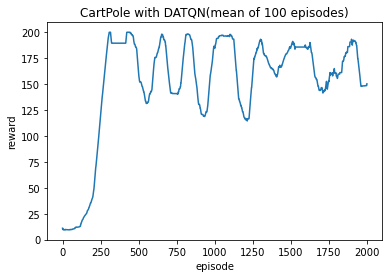

In [9]:
plt.plot(average_100_step)
plt.title("CartPole with DATQN(mean of 100 episodes)")
plt.xlabel("episode")
plt.ylabel("reward")

Text(0, 0.5, 'reward')

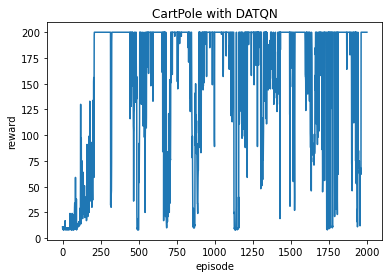

In [10]:
plt.plot(datqn_episode_reward)
plt.title("CartPole with DATQN")
plt.xlabel("episode")
plt.ylabel("reward")